# Challenge
Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [3]:
df.shape

(20052, 680)

In [4]:
df.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


In [7]:
df.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

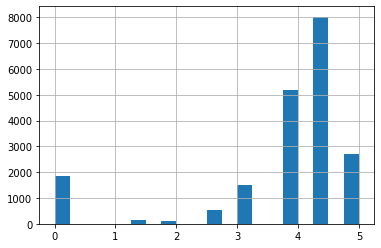

In [14]:
plt.hist(df.rating, bins=20)
plt.grid()
plt.show()

In [15]:
null_count = df.isnull().sum()
null_count[null_count > 0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [16]:
from sklearn.svm import SVR

In [17]:
svr = SVR(gamma='scale')

In [18]:
X = df.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1).copy()
y = df.rating.sample(frac=0.3, replace=True, random_state=1).copy()

In [20]:
%%time
svr.fit(X, y)

Wall time: 49.9 s


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [21]:
svr.score(X, y)

0.4099845913800794

In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
cross_vals = cross_val_score(svr, X, y, cv=5, n_jobs=-1)

In [24]:
cross_vals

array([0.19563385, 0.14683481, 0.15013401, 0.13597791, 0.16082192])

In [25]:
cross_vals.mean()

0.15788049975892332

Yipes!!!!!!!

In [26]:
X.shape

(6016, 674)

In [27]:
y.shape

(6016,)

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

Redefine X and y...

In [44]:
X = df.dropna().drop(columns=['title', 'rating']).copy()
y = df.dropna().rating.copy()

In [45]:
scaler = MinMaxScaler()

In [46]:
X = scaler.fit_transform(X)

In [47]:
%%time
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X)

Wall time: 2.35 s


In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3)

In [50]:
X_train.shape

(11104, 30)

In [51]:
y_train.shape

(11104,)

In [52]:
%%time
svr.fit(X_train, y_train)

Wall time: 15.5 s


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [53]:
svr.score(X_train, y_train)

0.1459053863847879

In [54]:
cross_vals2 = cross_val_score(svr, X_train, y_train, cv=5, n_jobs=-1)

In [55]:
cross_vals2

array([ 0.04333217, -0.00335128,  0.04010341,  0.0709101 ,  0.06238016])

In [56]:
cross_vals2.mean()

0.042674912873317636

That is extraordinarily bad...let's go back and see if we can engineer some defining features.

In [74]:
pd.Series({'adsf':12, 'dsafa':234}).value_counts()

234    1
12     1
dtype: int64

In [85]:
corrs = {}
for col in df.columns[1:]:
    corrs[col] = abs(df.rating.corr(df[col]))
corrs_ser = pd.Series(corrs)

32

In [94]:
corrs_ser[corrs_ser>.0552].index

Index(['rating', 'alcoholic', 'bake', 'bitters', 'bon appétit', 'brandy',
       'chartreuse', 'cocktail', 'cocktail party', 'condiment',
       'créme de cacao', 'dinner', 'drink', 'fall', 'fortified wine', 'gin',
       'harpercollins', 'house & garden', 'kosher', 'lime juice', 'liqueur',
       'non-alcoholic', 'peanut free', 'pernod', 'roast', 'rum', 'sauté',
       'soy free', 'spirit', 'tree nut free', 'weelicious'],
      dtype='object')

In [95]:
high_corr_cols = ['alcoholic', 'bake', 'bitters', 'bon appétit', 'brandy',
       'chartreuse', 'cocktail', 'cocktail party', 'condiment',
       'créme de cacao', 'dinner', 'drink', 'fall', 'fortified wine', 'gin',
       'harpercollins', 'house & garden', 'kosher', 'lime juice', 'liqueur',
       'non-alcoholic', 'peanut free', 'pernod', 'roast', 'rum', 'sauté',
       'soy free', 'spirit', 'tree nut free', 'weelicious']

In [136]:
from sklearn.preprocessing import LabelEncoder

In [137]:
lab_enc = LabelEncoder()

In [118]:
X = df[high_corr_cols].copy()

In [138]:
y = df.rating.copy()
y = lab_enc.fit_transform(y)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [141]:
X_train.shape

(14036, 30)

In [142]:
y_train.shape

(14036,)

In [143]:
from sklearn.svm import SVC

In [144]:
svc = SVC(gamma='scale', decision_function_shape='ovo')

In [145]:
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [146]:
svc.score(X_train, y_train)

0.43295810772299803

In [147]:
cross_vals3 = cross_val_score(svc, X_train, y_train, cv=5, n_jobs=-1)

In [148]:
cross_vals3

array([0.4227208 , 0.42058405, 0.42058405, 0.4212402 , 0.4230221 ])

In [149]:
cross_vals3.mean()

0.42163023679417116

This looks like it pretty consistently classifies correctly 40% of the time.

In [150]:
svc.score(X_test, y_test)

0.42021276595744683

Performs about the same on the test data as well. The best way to do this is probably by digging further into the data. Using cursory model techniques, I think this is the best it'll get. (Definitely better than the 15% we got in the beginning).